<a href="https://colab.research.google.com/github/ngocbaosp/ML-Projects/blob/master/My_Caption_Notebook-10-epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding,BatchNormalization, Dropout, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
from keras.preprocessing import image
import keras
from keras import backend 
from keras.models import load_model
import time
from PIL import Image

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
ls "/content/drive/My Drive/Dataset"

encoded_test_images_inceptionV3.p
encoded_train_images_inceptionV3.p
features.pkl
Flickr8k_Dataset/
Flickr8k_text/
imageCaption.pkl
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
vocab.p


In [0]:
DataPath = "/content/drive/My Drive/Dataset/"

In [0]:
# code to make caption dictionary whose keys are image file name and values are image caption.
token_dir = DataPath+ "Flickr8k_text/Flickr8k.token.txt"

image_captions = open(token_dir).read().split('\n')
caption = {}    
for i in range(len(image_captions)-1):
    id_capt = image_captions[i].split("\t")
    id_capt[0] = id_capt[0][:len(id_capt[0])-2] # to rip off the #0,#1,#2,#3,#4 from the tokens file
    if id_capt[0] in caption:
        caption[id_capt[0]].append(id_capt[1])
    else:
        caption[id_capt[0]] = [id_capt[1]]



In [7]:
caption['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

 <h3> We have to make two files named "trainimgs.txt" and "testImages.txt" that will have start and end token at the start and end of each caption respectively.  </h3>

In [0]:

train_imgs_id = open(DataPath+"Flickr8k_text/Flickr_8k.trainImages.txt").read().split('\n')[:-1]


train_imgs_captions = open(DataPath+"Flickr8k_text/trainimgs.txt",'w')
for img_id in train_imgs_id:
    for captions in caption[img_id]:
        desc = "<start> "+captions+" <end>"
        train_imgs_captions.write(img_id+"\t"+desc+"\n")
        train_imgs_captions.flush()
train_imgs_captions.close()

test_imgs_id = open(DataPath+"Flickr8k_text/Flickr_8k.testImages.txt").read().split('\n')[:-1]

test_imgs_captions = open(DataPath+"Flickr8k_text/testimgs.txt",'w')
for img_id in test_imgs_id:
    for captions in caption[img_id]:
        desc = "<start> "+captions+" <end>"
        test_imgs_captions.write(img_id+"\t"+desc+"\n")
        test_imgs_captions.flush()
test_imgs_captions.close()

In [0]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

<h3> We are using inceptionV3 model to extract features from images. We will take advantage of transfer leraning and use pretrained weights . Keras allows to upload pretrained weights.We will only change the output layer of the model, now our output will be second last layer of the model which gives output (2048,) </h3>

In [11]:
#model = InceptionV3(weights='imagenet')
model = InceptionV3(weights=DataPath+'inception_v3_weights_tf_dim_ordering_tf_kernels.h5')


W0813 06:29:41.561582 140246177781632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 06:29:41.605066 140246177781632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 06:29:41.613588 140246177781632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 06:29:41.655528 140246177781632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0813 06:29:41.656616 1402461777

In [0]:
new_input = model.input
new_output = model.layers[-2].output

model_new = Model(new_input, new_output)

<h3> Encode function takes in image path and outputs the vector using the inception model</h3>

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [0]:
images = DataPath+'Flickr8k_Dataset/'

In [0]:

train_imgs_id = open(DataPath+"Flickr8k_text/Flickr_8k.trainImages.txt").read().split('\n')[:-1]
test_imgs_id = open(DataPath+"Flickr8k_text/Flickr_8k.testImages.txt").read().split('\n')[:-1]
encoding_train = {}
#for img in tqdm(train_imgs_id): #tqdm instantly make your loops show a smart progress meter
#    path = images+str(img)
#    encoding_train[img] = encode(path)

In [0]:
#with open(DataPath+"encoded_train_images_inceptionV3.p", "wb") as encoded_pickle: 
#    pickle.dump(encoding_train, encoded_pickle) #python object can be pickled so that it can be saved on disk. 

In [0]:
encoding_train = pickle.load(open(DataPath+'encoded_train_images_inceptionV3.p', 'rb'))

In [18]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [0]:
encoding_test = {}
#for img in tqdm(test_imgs_id):
#    path = images+str(img)
#    encoding_test[img] = encode(path)

In [0]:
#with open(DataPath+"encoded_test_images_inceptionV3.p", "wb") as encoded_pickle:
#    pickle.dump(encoding_test, encoded_pickle)

In [0]:
encoding_test = pickle.load(open(DataPath+'encoded_test_images_inceptionV3.p', 'rb'))

In [0]:
dataframe = pd.read_csv(DataPath+'Flickr8k_text/trainimgs.txt', delimiter='\t')
captionz = []
img_id = []
dataframe = dataframe.sample(frac=1)
iter = dataframe.iterrows()

for i in range(len(dataframe)):
    nextiter = next(iter)
    captionz.append(nextiter[1][1])
    img_id.append(nextiter[1][0])

no_samples=0
tokens = []
tokens = [i.split() for i in captionz]
for caption in captionz:
    no_samples+=len(caption.split())-1

<h3> Note: Every time you tokenize a now vocab , it assigns different index positions to every word. so if you want to use my weights it is advisable to only load the "vocab.p" file. but if you want to train your own model feel free to uncomment next cell's code. </h3>
<h4>i trained my model for 10 epochs and tokenized the vocab again. it overwrote the "vocab.p ". so i had to train my model all over again. </h4>

In [0]:
vocab= [] 
for token in tokens:
    vocab.extend(token)
vocab = list(set(vocab))
#with open(DataPath+"vocab.p", "wb") as pickle_d:
#   pickle.dump(vocab, pickle_d)

In [0]:
vocab= pickle.load(open(DataPath+'vocab.p', 'rb'))

In [25]:
print (len(vocab))

vocab_size = len(vocab)

8256


In [0]:
word_idx = {val:index for index, val in enumerate(vocab)}
idx_word = {index:val for index, val in enumerate(vocab)}

In [27]:
word_idx['end']

2799

In [28]:
caption_length = [len(caption.split()) for caption in captionz]
max_length = max(caption_length)
max_length # maximum lenght of a caption.

40

In [0]:
def data_process(batch_size):
    partial_captions = []
    next_words = []
    images = []
    total_count = 0
    while 1:
    
        for image_counter, caption in enumerate(captionz):
            current_image = encoding_train[img_id[image_counter]]
    
            for i in range(len(caption.split())-1):
                total_count+=1
                partial = [word_idx[txt] for txt in caption.split()[:i+1]]
                partial_captions.append(partial)
                next = np.zeros(vocab_size)
                next[word_idx[caption.split()[i+1]]] = 1
                next_words.append(next)
                images.append(current_image)

                if total_count>=batch_size:
                    next_words = np.asarray(next_words)
                    images = np.asarray(images)
                    partial_captions = sequence.pad_sequences(partial_captions, maxlen=max_length, padding='post')
                    total_count = 0
                
                    yield [[images, partial_captions], next_words]
                    partial_captions = []
                    next_words = []
                    images = []

In [0]:
EMBEDDING_DIM = 300 

In [0]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = keras.layers.Input(shape=(2048,))
    
    fe1 = Dense(EMBEDDING_DIM, activation='relu')(inputs1)
    fe2 = RepeatVector(max_length)(fe1)

    
    inputs2 = keras.layers.Input(shape=(max_length,))
    se1 = Embedding(vocab_size,EMBEDDING_DIM )(inputs2)
    se2 = Bidirectional(LSTM(256,return_sequences=True))(se1)
    se3 = Dropout(0.5)(se2)
    se4 = BatchNormalization()(se3)
    se5 = TimeDistributed(Dense(EMBEDDING_DIM))(se4)
    
    # decoder model
    
    
    decoder1 = keras.layers.merge.Concatenate()([fe2, se5])
    
    
    decoder2 = Dropout(0.5)(decoder1)
    decoder3 = BatchNormalization()(decoder2)
    
    decoder4 =Bidirectional(LSTM(1000,return_sequences=False))(decoder3)
    decoder5 =Dense(vocab_size)(decoder4)
    outputs = Activation('softmax')(decoder5)

    
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    # summarize model
    print(model.summary())
    from keras.utils import plot_model
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [32]:
fin_model = define_model(vocab_size, max_length)

W0813 06:30:13.901722 140246177781632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0813 06:30:21.522844 140246177781632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 40, 512)      1140736     embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_1 

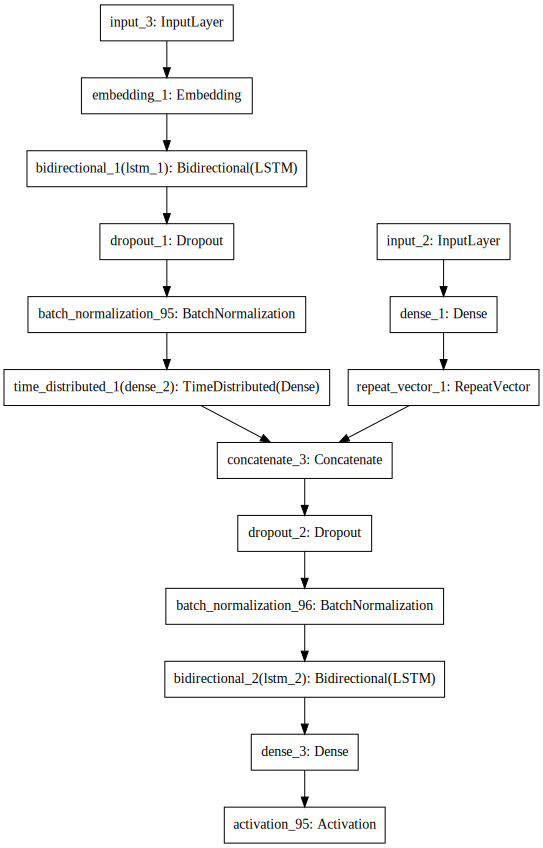

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(fin_model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
#fin_model.load_weights(DataPath+"imageCaption10.h5")

In [34]:
epoch = 10
batch_size = 128
history = fin_model.fit_generator(data_process(batch_size=batch_size), steps_per_epoch=no_samples/batch_size, epochs=epoch, verbose=1, callbacks=None,use_multiprocessing=True)


W0813 06:30:22.538272 140246177781632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
2996/2995 [==============================] - 2240s 748ms/step - loss: 3.6175 - acc: 0.3452
Epoch 2/10
2996/2995 [==============================] - 2230s 744ms/step - loss: 2.9064 - acc: 0.4002
Epoch 3/10
2996/2995 [==============================] - 2249s 751ms/step - loss: 2.6019 - acc: 0.4221
Epoch 4/10
2996/2995 [==============================] - 2251s 751ms/step - loss: 2.3550 - acc: 0.4433
Epoch 5/10
2996/2995 [==============================] - 2262s 755ms/step - loss: 2.1538 - acc: 0.4674
Epoch 6/10
2996/2995 [==============================] - 2243s 749ms/step - loss: 1.9882 - acc: 0.4904
Epoch 7/10
2996/2995 [==============================] - 2258s 754ms/step - loss: 1.8464 - acc: 0.5126
Epoch 8/10
2996/2995 [==============================] - 2264s 756ms/step - loss: 1.7221 - acc: 0.5350
Epoch 9/10
2996/2995 [==============================] - 2268s 757ms/step - loss: 1.6124 - acc: 0.5546
Epoch 10/10
2996/2995 [==============================] - 2266s 756ms/step - loss: 

In [0]:
fin_model.save(DataPath+"imageCaption10.pkl")

In [0]:
fin_model.save_weights(DataPath+"imageCaption10.h5")

In [37]:
<h3>In order to predict  results we used  greedy search and as well as beam search. </h3>
<h4>In greedy serach we pick one word that has highest prediction value.In contrast in beam search we pick as many words as we like each time a prediction is made. Suppose we picked 3 words then we will take into acccount the probability of whole caption by using first word , second word and third word separately. whichever is giving us the maximum probabilty for the caption we will pich that one word.</h4>

SyntaxError: ignored

In [0]:
def predict_captions(image_file):
    start_word = ["<start>"]
    while 1:
        now_caps = [word_idx[i] for i in start_word]
        now_caps = sequence.pad_sequences([now_caps], maxlen=max_length, padding='post')
        e = encoding_test[image_file]
        preds = fin_model.predict([np.array([e]), np.array(now_caps)])
        word_pred = idx_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_length: 
    #keep on predicting next word unitil word predicted is <end> or caption lenghts is greater than max_lenght(40)
            break
            
    return ' '.join(start_word[1:-1])

In [0]:
def beam_search_predictions(image_file, beam_index = 3):
    start = [word_idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            now_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            e = encoding_test[image_file]
            preds = fin_model.predict([np.array([e]), np.array(now_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top Beam index = 3  predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

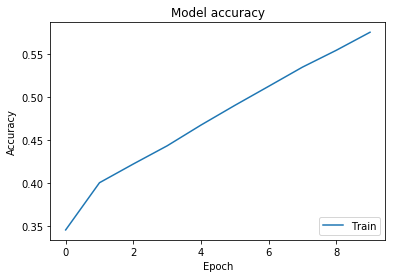

In [45]:
import matplotlib.pyplot as plt #for plotting
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


KeyError: ignored

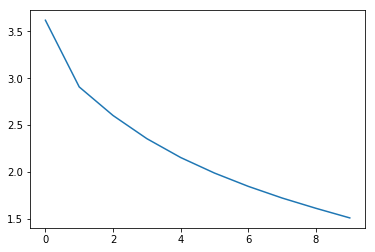

In [46]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

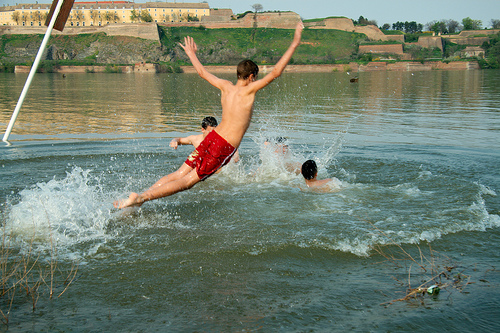

In [41]:
image_file ="3430607596_7e4f74e3ff.jpg"
test_image =  images + image_file
Image.open(test_image)

In [42]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

Greedy search: A girl in a red shirt jumps into the water .
Beam Search, k=3: A girl in a red shirt jumps into the water .
Beam Search, k=5: A girl in a red shirt jumps into the water .
Beam Search, k=7: A dark haired man jumps in the water .


In [0]:
image_file ="3255482333_5bcee79f7e.jpg"
test_image =  images + image_file
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
image_file ="3168123064_d1983b8f92.jpg"
test_image =  images + image_file
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
image_file ="3316725440_9ccd9b5417.jpg"
test_image =  images + image_file
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
image_file ="3218480482_66af7587c8.jpg"
test_image =  images + image_file
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
image_file ="2541104331_a2d65cfa54.jpg"
test_image =  images + image_file
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
image_file ="309687244_4bdf3b591f.jpg"
test_image =  images + image_file
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
image_file ="2542662402_d781dd7f7c.jpg"
test_image =  images + image_file
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
image_file ="2654514044_a70a6e2c21.jpg"
test_image =  images + image_file
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
image_file ="abc.png"
test_image =  images + image_file
Image.open(test_image)
encoding_test[image_file] = encode(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [0]:
image_file ="aaa.jpg"
test_image =  images + image_file
encoding_test[image_file] = encode(test_image)
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

In [0]:

image_file ="dog.jpg"
test_image =  image_file
encoding_test[image_file] = encode(test_image)
Image.open(test_image)

In [0]:
print ('Greedy search:', predict_captions(image_file))
print ('Beam Search, k=3:', beam_search_predictions(image_file, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(image_file, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(image_file, beam_index=7))

https://github.com/jcjohnson/densecap#running-on-new-images

https://github.com/Faizan-E-Mustafa/Image-Captioning?fbclid=IwAR2ttkjCg0LHtRaYq_SaLgRryxwHC0ZmefPwxIgjb5MA-f3Xq8nG8P5NrTc